# CROSS VALIDATION : REPEATED K-FOLD 

<br>

## Introduction

<br>
<b>Repeatead k-fold cross-validation is often used in hope to obtain a more robust estimate</b> : repetition (with shuffling) helps mitigating the fact that, in regular k-fold cv, whole groups of data points near to each other (a 'fold') will always be selected together for either train or test set, the aim is to expose the model to more randomness.

In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

#import sklearn.linear_model as lm
import sklearn.neighbors as nbr
from sklearn.model_selection import KFold
import sklearn.metrics as mtr

import utilcompute as uc
from pprint import pprint


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']

#print('df.shape[0] : ', df.shape[0])


In [3]:
#df.describe()

In [4]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [5]:
target = 'species'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

df_std = uc.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'petal length': 173.96896536339727,
 'petal width': 55.48868864572551,
 'sepal length': 264.7457109493044,
 'sepal width': 97.111605833803296}

df_std : 

{'petal length': 31.397291650719751,
 'petal width': 16.141563956997683,
 'sepal length': 7.1031134428332869,
 'sepal width': 2.0990386257420881}


In [7]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [8]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['petal length' 'petal width' 'sepal length' 'sepal width' 'species']


In [9]:
# GLOBAL PARAMETERS 

n_splits = 10
seeds = range(1, 50 + 1)

print('k (# of folds) : ', n_splits)
print('seeds : ', seeds)


k (# of folds) :  10
seeds :  range(1, 51)


In [10]:
columns = ['seed', 'iteration', 'err_train', 'err_test']
results_df = pd.DataFrame(data = None, index = None, columns = columns)

results_index = 0
for (s_index, s) in enumerate(seeds):

    kf = KFold(n_splits = n_splits, shuffle = True, random_state = s)    
    
    for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :

        fold_train = df.iloc[train_positions]   
        fold_test = df.iloc[test_positions]  

        # if (k == 0):
        #    print('train indices : {0} - {1}'.format(fold_train.index.values[:3], fold_train.index.values[-3:]))
        #    print('test  indices : {0} - {1}'.format(fold_test.index.values[:3], fold_test.index.values[-3:]))
        #    print()

        #model = lm.LogisticRegression()
        model = nbr.KNeighborsClassifier(n_neighbors = 5)
        model.fit(fold_train[features], fold_train[target])

        y_pred_train = model.predict(fold_train[features])
        y_pred_test = model.predict(fold_test[features])

        #metrics_train = uc.compute_classification_metrics(y = fold_train[target], y_pred = y_pred_train)
        #metrics_test = uc.compute_classification_metrics(y = fold_test[target], y_pred = y_pred_test)
    
        acc_train = mtr.accuracy_score(y_true = fold_train[target], y_pred = y_pred_train, normalize = True, sample_weight = None)
        acc_test = mtr.accuracy_score(y_true = fold_test[target], y_pred = y_pred_test, normalize = True, sample_weight = None)
            
        values_dict = {
            'seed' : s,
            'iteration' : k + 1,            
            #'err_train' : 1 - metrics_train['ACC'],
            #'err_test' : 1 - metrics_test['ACC'],
            'err_train' : 1 - acc_train,
            'err_test' : 1 - acc_test,
        }

        results_df.loc[results_index] = values_dict  
        results_index += 1

results_df = results_df.astype(dtype = 'float')

#condition = (results_df['iteration'] == 1)
#print(results_df[condition])


In [11]:
print()
print('train | err mean : ', results_df['err_train'].mean())
print('train | err std  : ', results_df['err_train'].std())

print()
print('test  | err mean : ', results_df['err_test'].mean())
print('test  | err std  : ', results_df['err_test'].std())



train | err mean :  0.041170370370370316
train | err std  :  0.009709277856986755

test  | err mean :  0.05106666666666651
test  | err std  :  0.05548290060978883


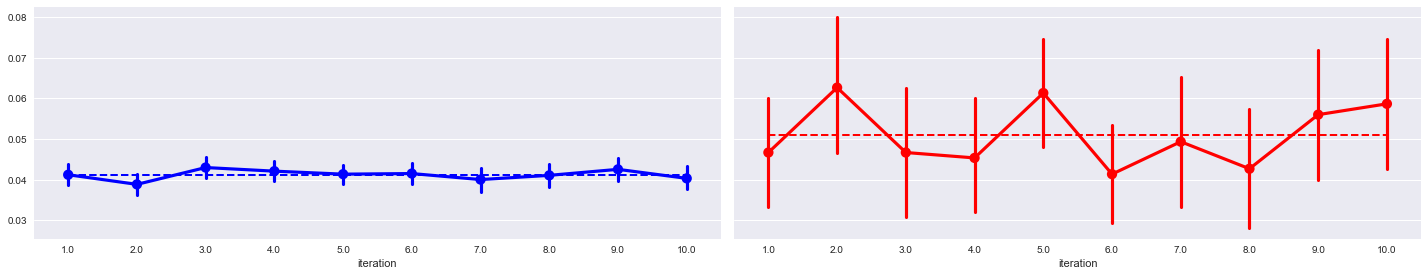

In [21]:
fig, axs = plt.subplots(nrows = 1, ncols = 2 , figsize=(20, 4), sharey = True)  

it_min = results_df['iteration'].min() - 1 # (don't know why, but without -1 the plot starts in 2 and ends in 11)
it_max = results_df['iteration'].max() - 1 # (don't know why, but without -1 the plot starts in 2 and ends in 11)

err_train_mean = results_df['err_train'].mean()
err_test_mean = results_df['err_test'].mean()

sns.pointplot(x = 'iteration', y = 'err_train', data = results_df, join = True, color = 'blue', ax = axs[0], label = 'err train')
axs[0].plot( (it_min, it_max), (err_train_mean, err_train_mean), color = 'blue', lw = 2, linestyle = '--')
axs[0].set_ylabel('')    

sns.pointplot(x = 'iteration', y = 'err_test', data = results_df, join = True, color = 'red', ax = axs[1], label = 'err test')
axs[1].plot( (it_min, it_max), (err_test_mean, err_test_mean), color = 'red', lw = 2, linestyle = '--')
axs[1].set_ylabel('')  

plt.tight_layout()
plt.show()


## Considerations

<br>
We can observe :

<br>
<ul style="list-style-type:square">
    <li>
        <b>small bias</b>
    </li>
    <br>
    <li>
        <b>small variance</b>
    </li>
    <br>  
</ul>

<br>
<b>Further questions/issues</b> :

<br>
<ul style="list-style-type:square">
    <li>
        repeated k-fold cross validation is even more computationally expensive than regular cv 
        the size we choose for the test set 
    </li>
</ul>